# River Dart Analysis

In [71]:
import sqlite3 as lite
import csv
import math
import time
import sys
import json
import pandas as pd
import os
import ftplib
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

fdir = os.path.abspath(os.path.dirname('__file__'))



In [72]:
time_format = "%Y-%m-%dT%H:%M"


k = 0.12
scale_m = 1.91
scale_a = 0.234
delay = np.timedelta64(60, 'm') # 60 minutes

def f(x):
    return math.exp(k*x)
def g(x):
    return (scale_m * x) + scale_a
def f_inv(x):
    return math.log(x) / k
def g_inv(x):
    return (x - scale_a) / scale_m

In [73]:
df = pd.read_csv(os.path.join(fdir, 'historical_data/dart.csv'))

In [74]:
print df.head()
print df.tail()

             timestamp  level  tot_rate  new
0  2008-01-01 00:00:00  0.456       0.0  0.0
1  2008-01-01 00:15:00  0.458       NaN  0.0
2  2008-01-01 00:30:00  0.461       0.0  0.2
3  2008-01-01 00:45:00  0.466       NaN  0.0
4  2008-01-01 01:00:00  0.472       0.0  0.0
                  timestamp  level  tot_rate  new
286267  2016-02-29 22:45:00  0.389       NaN  0.0
286268  2016-02-29 23:00:00  0.389     0.386  0.2
286269  2016-02-29 23:15:00  0.389       NaN  0.0
286270  2016-02-29 23:30:00  0.389     0.537  0.4
286271  2016-02-29 23:45:00  0.389       NaN  0.0


In [75]:
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df = df.sort_index()
df.head()

,level,tot_rate,new
timestamp,,,
2008-01-01 00:00:00,0.456,0.0,0.0
2008-01-01 00:15:00,0.458,NaN,0.0
2008-01-01 00:30:00,0.461,0.0,0.2
2008-01-01 00:45:00,0.466,NaN,0.0
2008-01-01 01:00:00,0.472,0.0,0.0


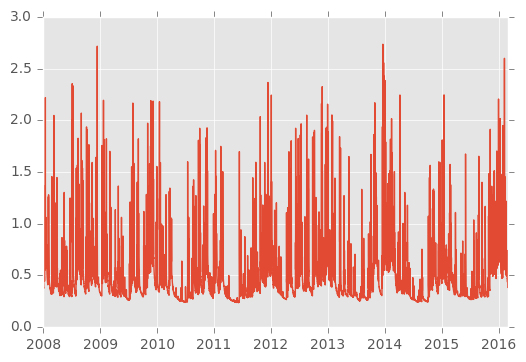

In [76]:
plt.plot(df.level.fillna(0))

In [77]:
print df.shape
# Fill  missing timestamps if any
min_time = min(df.index)
max_time = max(df.index)
rng = pd.date_range(min_time, max_time, freq='15Min')
df = df.reindex(rng)
print df.shape

(286272, 3)
(286272, 3)


In [78]:
df['rain'] = df['tot_rate'].diff(periods=2)
df.loc[df['rain'] < 0, 'rain'] = 0 
# interpolate and div 2 to get actual rain every 15 min
df['rain'] = df['rain'].interpolate()
df['rain'] = df['rain'] / 2

# multiply by 4 to get rain rate per hour
df['rain'] = df['rain'] * 2


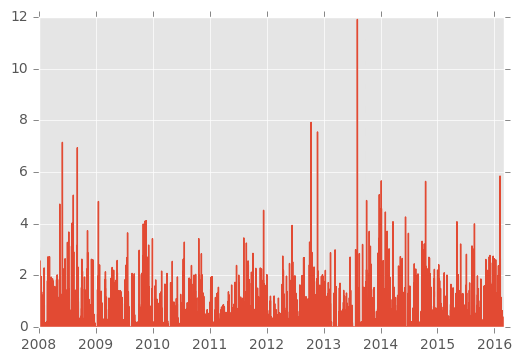

In [79]:
plt.plot(df.rain.fillna(0))

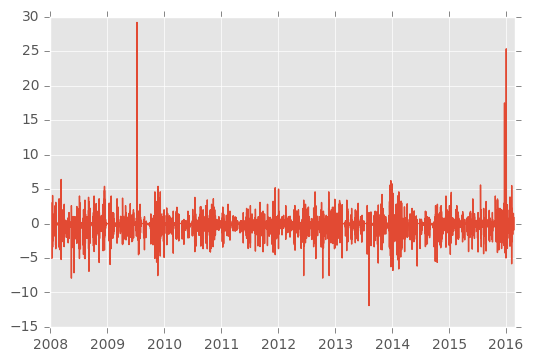

In [80]:
plt.plot(df.new.fillna(0) - 2* df.rain.fillna(0))

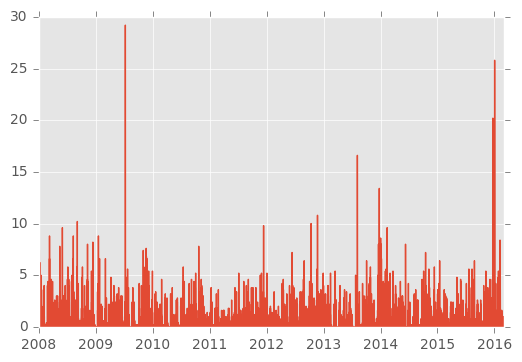

In [90]:
plt.plot(df.new.fillna(0))

In [101]:
start_time = time.time()

df['rain'] = df['rain'].fillna(0)
df['storage'] = np.nan
df['predict'] = np.nan

# Calculate initial storage
init_storage = 0 #f_inv(g_inv(latest_level))
df.loc[df.index.min(), 'storage'] = init_storage

# Run iteration for indexes > latest_level_update
storage = init_storage
df_model = df[(df.index < df.index[5000]) & (df.index > df.index.min() + delay)]
for i,r in df_model.iterrows():
    rain = df.loc[i - delay, 'rain']
    #predict = g(f(storage))
    storage = storage + rain - f(storage)
    df.loc[i, 'storage'] = storage
    #df.loc[i, 'predict'] = predict
    
print("--- %s seconds ---" % (time.time() - start_time))


df.predict = df.storage.apply(lambda x: g(f(x)))


print("--- %s seconds ---" % (time.time() - start_time))


--- 233.301186085 seconds ---
--- 233.450705051 seconds ---


                     level  tot_rate  new    rain  storage  predict
2008-01-01 00:15:00  0.458       NaN  0.0  0.0000      NaN      NaN
2008-01-01 00:30:00  0.461     0.000  0.2  0.0000      NaN      NaN
2008-01-01 00:45:00  0.466       NaN  0.0  0.0000      NaN      NaN
2008-01-01 01:00:00  0.472     0.000  0.0  0.0000      NaN      NaN
2008-02-22 02:00:00  0.320     0.269  0.2  0.0680      NaN      NaN
2008-02-22 02:15:00  0.320       NaN  0.0  0.0525      NaN      NaN
2008-02-22 02:30:00  0.320     0.306  0.2  0.0370      NaN      NaN
2008-02-22 02:45:00  0.320       NaN  0.0  0.1225      NaN      NaN
2008-02-22 03:00:00  0.320     0.514  0.4  0.2080      NaN      NaN
2008-02-22 03:15:00  0.321       NaN  0.0  0.1040      NaN      NaN


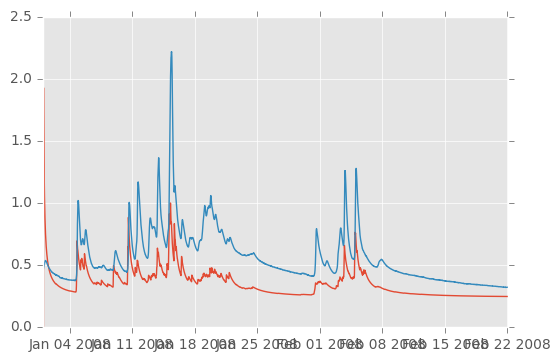

In [104]:
print df[df.predict.isnull()].head(10)
df1 = df[:5000]

plt.plot(df1.predict.fillna(0))
plt.plot(df1.level.fillna(0))

plt.show()

In [100]:
df.head()

,level,tot_rate,new,rain,storage,predict
2008-01-01 00:00:00,0.456,0.0,0.0,0.0,0.0,2.144
2008-01-01 00:15:00,0.458,NaN,0.0,0.0,NaN,NaN
2008-01-01 00:30:00,0.461,0.0,0.2,0.0,NaN,NaN
2008-01-01 00:45:00,0.466,NaN,0.0,0.0,NaN,NaN
2008-01-01 01:00:00,0.472,0.0,0.0,0.0,NaN,NaN


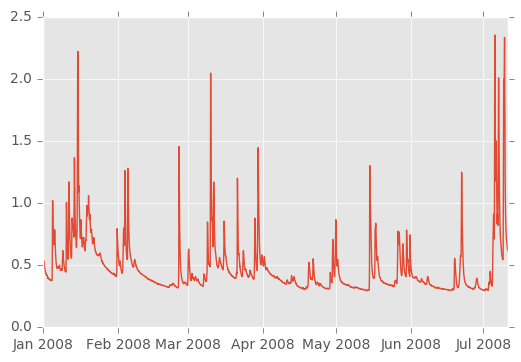

In [68]:
plt.plot(df1.level.fillna(0))


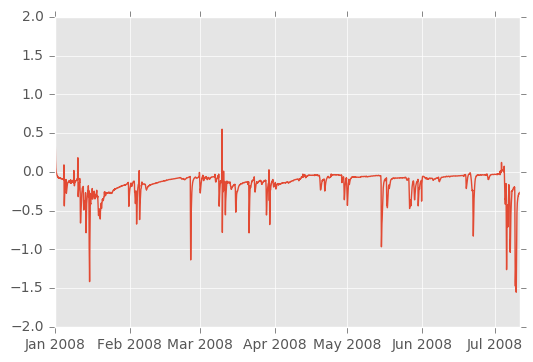

In [70]:
plt.plot(df1.predict.fillna(0) - df1.level.fillna(0))
